In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Pixel:
    
    def __init__(self, pos):
        """
        Square of unit side. Its center (x,y) has integer coordinates.
        At creation, the class computes also the boundaries of the pixels
        x1, x2, y1, y2.
        """
        self.x = round(pos[0])
        self.y = round(pos[1])
        self.x1 = self.x - 0.5
        self.x2 = self.x + 0.5
        self.y1 = self.y - 0.5
        self.y2 = self.y + 0.5
        
class Line:
    
    def __init__(self, p1, p2):
        """
        Line that passes between two points. Also the angular coef and intercept
        of the inverse line are computed at creation.
        """
        if p2[0] - p1[0] != 0:
            self.m = (p2[1] - p1[1]) / (p2[0] - p1[0])
            self.b = p1[1] - self.m * p1[0]
        else:
            self.m = None
            self.b = None

        if self.m == None:
            self.m_inv = 0
            self.b_inv = p1[0]
        elif self.m != 0:
            self.m_inv = 1/self.m
            self.b_inv = -self.b/self.m
        else:
            self.m_inv = None
            self.b_inv = None      
            
    def y(self, x):
        """Position along the line at given x"""
        if self.m != None:
            return self.m * x + self.b 
        else:
            return None
    
    def x(self, y):
        """Position along the inverse line at given y"""
        if self.m_inv != None:
            return self.m_inv * y + self.b_inv 
        else:
            return None

In [3]:
def area_triangle(p1, p2, p3):
    p1, p2, p3 = np.array(p1), np.array(p2), np.array(p3)
    a, b, c = np.linalg.norm(p1-p2), np.linalg.norm(p2-p3), np.linalg.norm(p3-p1)
    s =  (a + b + c)/2
    return np.sqrt( s*(s - a)*(s - b)*(s - c) )

def area_quadrilateral(p1, p2, p3, p4):
    p1, p2, p3, p4 = np.array(p1), np.array(p2), np.array(p3), np.array(p4)
    diag = np.linalg.norm(p1-p3)
    a, b = np.linalg.norm(p1-p2), np.linalg.norm(p2-p3)
    s =  (a + b + diag)/2
    a1 = np.sqrt( s*(s - a)*(s - b)*(s - diag) )
    a, b = np.linalg.norm(p3-p4), np.linalg.norm(p4-p1)
    s =  (a + b + diag)/2
    a2 = np.sqrt( s*(s - a)*(s - b)*(s - diag) )
    return a1 + a2

In [4]:
def area_pixel_below_line(pixel, line, orient):
    """
    It computes the area within the pixel below the line.
    In the case of vertical line the are computed is on the right of the line.
    """
    x1, x2, y1, y2 = pixel.x1, pixel.x2, pixel.y1, pixel.y2
    l_x1 = line.y(x1)
    l_x2 = line.y(x2)
    l_y1 = line.x(y1)
    l_y2 = line.x(y2)
    
    area = 1
    if line.m == None:
        area = x2 - line.b_inv
        
    elif line.m >= 1:
        if l_x2 < y1:
            area = 0
        elif l_x2 < y2:
            area = (l_x2 - y1) * (x2 - l_y1) * 0.5
        elif l_x1 < y1:
            area = x2 - l_y2 + (l_y2 - l_y1) * 0.5
        elif l_x1 < y2:
            area = 1 - (y2 - l_x1) * (l_y2 - x1) * 0.5
        
    elif line.m >= 0:
        if l_x2 < y1:
            area = 0
        elif l_x1 < y1:
            area = (l_x2 - y1) * (x2 - l_y1) * 0.5
        elif l_x2 < y2:
            area = l_x1 - y1 + (l_x2 - l_x1) * 0.5
        elif l_x1 < y2:
            area = 1 - (y2 - l_x1) * (l_y2 - x1) * 0.5
        
    elif line.m >= -1:
        if l_x1 < y1:
            area = 0
        elif l_x2 < y1:
            area = (l_x1 - y1) * (l_y1 - x1) * 0.5
        elif l_x1 < y2:
            area = l_x2 - y1 + (l_x1 - l_x2) * 0.5
        elif l_x2 < y2:
            area = 1 - (y2 - l_x2) * (x2 - l_y2) * 0.5

    else:
        if l_x1 < y1:
            area = 0
        elif l_x1 < y2:
            area = (l_x1 - y1) * (l_y1 - x1) * 0.5
        elif l_x2 < y1:
            area = l_y2 - x1 + (l_y1 - l_y2) * 0.5
        elif l_x2 < y2:
            area = 1 - (y2 - l_x2) * (x2 - l_y2) * 0.5
    
    if orient:
        return area
    else:
        return 1 - area

In [5]:
dx_th = 1e-8

def find_intersection(pixel, point, adj_point, line):
    """
    It finds the intersection of the line connecting the point inside the pixel
    to the adj_point with a border of the pixel.
    It return an integer specifying the side of the pixel intersecting the line
    (0 -> north, 1 -> west, 2 -> south, 3 -> east) and the point of 
    the intersection (only the non trivial coordinate).
    """
    dx = point[0] - adj_point[0]
    dy = point[1] - adj_point[1]
    
    if dx >= dx_th:
        l_x1 = line.y(pixel.x1)
        if dy >= dx_th:
            if l_x1 < pixel.y1:
                return 2, line.x(pixel.y1)
            else:
                return 1, l_x1
        elif dy < dx_th and dy > -dx_th:
            return 1, point[1]
        else:
            if l_x1 > pixel.y2:
                return 0, line.x(pixel.y2)
            else:
                return 1, l_x1 
    elif dx < dx_th and dx > -dx_th:
        if dy > 0:
            return 2, point[0]
        else:
            return 0, point[0]
    else:
        l_x2 = line.y(pixel.x2)
        if dy > dx_th:
            if l_x2 < pixel.y1:
                return 2, line.x(pixel.y1)
            else:
                return 3, l_x2
        elif dy < dx_th and dy > -dx_th:
            return 3, point[1]
        else:
            if l_x2 > pixel.y2:
                return 0, line.x(pixel.y2)
            else:
                return 3, l_x2


def area_pixel_below_poligon(pixel, line_in, point_in, line_out, point_out, inner_points):
    """
    It compute the area within the pixel on the right of the broken line that starts from line_in,
    connects all the inner_points and exit though line_out
    """
    
    def get_extreme_val(side_i):
        if side_i == 0:
            return pixel.x1
        elif side_i == 1:
            return pixel.y1
        elif side_i == 2:
            return pixel.x2
        else:
            return pixel.y2
        
    def get_height(side_i):
        if side_i == 0:
            return pixel.y2 - inner_points[0][1]
        elif side_i == 1:
            return inner_points[0][0] - pixel.x1
        elif side_i == 2:
            return inner_points[0][1] - pixel.y1
        else:
            return pixel.x2 - inner_points[0][0]
        
    def get_coords_on_border(side_i, coord):
        if side_i == 0:
            return np.array([coord, pixel.y2])
        elif side_i == 1:
            return np.array([pixel.x1, coord])
        elif side_i == 2:
            return np.array([coord, pixel.y1])
        else:
            return np.array([pixel.x2, coord])
        
    def remaining_area():
        if len(inner_points) == 1:
            return 0
        elif len(inner_points) == 2:
            point_border = get_coords_on_border(side_out, val_out)
            return area_triangle(inner_points[0], inner_points[1], point_border)
        elif len(inner_points) == 3:
            point_border = get_coords_on_border(side_out, val_out)
            return area_quadrilateral(inner_points[0], inner_points[1], inner_points[2], point_border)
        else:
            raise Exception('invalid inner_points length')
        
    #print('in', line_in.m, line_in.m_inv)
    side_in, val_in = find_intersection(pixel, inner_points[0], point_in, line_in)
    #print('out', line_out.m, line_out.m_inv)
    side_out, val_out = find_intersection(pixel, inner_points[-1], point_out, line_out)
    
    if side_in == side_out:
        area = abs(val_in - val_out) * get_height(side_in) * 0.5
        return area + remaining_area()
    else:
        area = abs(get_extreme_val(side_in) - val_in) * get_height(side_in)
        #print(get_extreme_val(side_in), get_height(side_in), area)
        area += (1 - abs(get_extreme_val(side_out) - val_out)) * get_height(side_out)
        #print(get_extreme_val(side_out), get_height(side_out), area)
        
        for _ in range(4):
            side_in = (side_in + 1)%4
            if side_in == side_out:
                break
            area += get_height(side_in)
        #print(area)
        
        return area * 0.5 + remaining_area()

In [6]:
def compute_lines(shape):
    close_shape = np.row_stack((shape,shape[0]))
    lines, orients = [], []
    for i in range(len(close_shape)-1):
        lines.append(Line(close_shape[i], close_shape[i+1]))
        o = shape[(i+1)%len(shape)][0] >= shape[i][0]
        if shape[(i+1)%len(shape)][0] == shape[i][0]:
            o = shape[(i+1)%len(shape)][1] > shape[i][1]
        orients.append(o)
    return lines, orients


def find_vert_unique(vert_pixels):
    L = len(vert_pixels)
    uniques, counts = [], []
    for i in range(L):
        v = vert_pixels[i]
        found = False
        for j in range(len(uniques)):
            if vert_pixels[uniques[j]][0] == v[0] and vert_pixels[uniques[j]][1] == v[1]:
                counts[j] += 1
                found = True
        if not found:
            uniques.append(i)
            counts.append(1)
            
    for i, u in enumerate(uniques):
        if counts[i] > 1 and counts[i] < L:
            for _ in range(L):
                v = vert_pixels[u]
                i_left = (u-1)%L
                if vert_pixels[i_left][0] == v[0] and vert_pixels[i_left][1] == v[1]:
                    uniques[i] = i_left
                    u = i_left
                else:
                    break
                
    return uniques, counts


def compute_vertex_shade(pixels, pixel_offset, shape, lines):
    round_vert = [[round(p[0]), round(p[1])] for p in shape]
    unique_vert_i, counts = find_vert_unique(round_vert)
    #print(unique_vert_i, counts)
    L = len(shape)
    
    # A shape all contained in a pixel should not happen, but in case, the pixel is set to 1 
    if len(unique_vert_i) == 1:
        p = shape[unique_vert_i[0]]
        px = Pixel([p[0], p[1]])
        pixels[px.y-pixel_offset[0], px.x-pixel_offset[1]] = 1 
    else:
        for i in range(len(unique_vert_i)):
            p = shape[unique_vert_i[i]]
            px = Pixel([p[0], p[1]])
            p_in = shape[(unique_vert_i[i]-1)%L]
            p_out = shape[(unique_vert_i[i]+counts[i])%L]
            #print(px.x, px.y, p_in, p_out)
            line_in, line_out = lines[(unique_vert_i[i]-1)%L], lines[(unique_vert_i[i]+counts[i]-1)%L]
            points = shape[unique_vert_i[i]:unique_vert_i[i]+counts[i]]
            if unique_vert_i[i]+counts[i] > L-1:
                points = np.row_stack((points, shape[0:(unique_vert_i[i]+counts[i])%L]))
            #print(points)
            area = area_pixel_below_poligon(px, line_in, p_in, line_out, p_out, points)
            #print(i, area)
            pixels[px.y-pixel_offset[0], px.x-pixel_offset[1]] = area
    return pixels
            

def compute_raycasts(shape, pixels, pixel_offset, lines):
    ni, nj = pixels.shape
    close_shape = np.row_stack((shape,shape[0]))
    n_crossing_xrays, n_crossing_yrays = np.zeros((ni+1,nj+1)), np.zeros((ni+1,nj+1))
    side_infox = [[[] for _ in range(nj+1)] for _ in range(ni+1)]
    side_infoy = [[[] for _ in range(ni+1)] for _ in range(nj+1)]
    
    for k in range(len(shape)):
        v1, v2 = close_shape[k], close_shape[k+1]
        
        max_pix_vert_y = int(np.ceil(max(v1[1], v2[1]) - 0.5) - pixel_offset[0])
        min_pix_vert_y = int(np.ceil(min(v1[1], v2[1]) + 0.5) - pixel_offset[0])
        max_pix_vert_x = int(np.ceil(max(v1[0], v2[0]) - 0.5) - pixel_offset[1])
        min_pix_vert_x = int(np.ceil(min(v1[0], v2[0]) + 0.5) - pixel_offset[1])
        #print(v1, v2, min_pix_vert_x, max_pix_vert_x, min_pix_vert_y, max_pix_vert_y)
        
        for pvi in range(min_pix_vert_y, max_pix_vert_y+1):
            pvj = 0
            for pvj in range(0, min_pix_vert_x):
                n_crossing_xrays[pvi, pvj] += 1
            for pvj in range(min_pix_vert_x, max_pix_vert_x+1):
                xside = lines[k].x(pvi-0.5+pixel_offset[0])
                if xside >= pvj-0.5+pixel_offset[1]:
                    n_crossing_xrays[pvi, pvj] += 1
                else:
                    pvj -= 1
                    break       
            side_infox[pvi][pvj].append(k)
        
        for pvj in range(min_pix_vert_x, max_pix_vert_x+1):
            pv1 = 0
            for pvi in range(0, min_pix_vert_y):
                n_crossing_yrays[pvi, pvj] += 1
            for pvi in range(min_pix_vert_y, max_pix_vert_y+1):
                yside = lines[k].y(pvj-0.5+pixel_offset[1])
                if yside >= pvi-0.5+pixel_offset[0]:
                    n_crossing_yrays[pvi, pvj] += 1
                else:
                    pvi -= 1
                    break
            side_infoy[pvj][pvi].append(k)
            
    return n_crossing_xrays, n_crossing_yrays, side_infox, side_infoy


def apply_raycasting(shape, pixels, pixel_offset, lines, orients):
    
    n_crossing_xrays, n_crossing_yrays, side_infox, side_infoy = compute_raycasts(shape, pixels, pixel_offset, lines)   
    #print(n_crossing_xrays)
    #print(n_crossing_yrays[::-1])
    #print(side_infox)
    #print(side_infoy)
    ni, nj = pixels.shape
    for i in range(ni):
        for j in range(nj):
            
            # Internal external check with raycasts
            if n_crossing_xrays[i,j] == n_crossing_xrays[i,j+1] and n_crossing_xrays[i+1,j] == n_crossing_xrays[i+1,j+1] and \
               n_crossing_yrays[i,j] == n_crossing_yrays[i+1,j] and n_crossing_yrays[i,j+1] == n_crossing_yrays[i+1,j+1]:
                #print(i, j, 'raycast')
                if n_crossing_xrays[i,j]%2 == 0:
                    pixels[i,j] = 0
                else:
                    pixels[i,j] = 1
            
            else:
                if pixels[i,j] != -1:
                    continue
                    
                sides = set()
                for s in side_infox[i][j]: sides.add(s)
                for s in side_infox[i+1][j]: sides.add(s)
                for s in side_infoy[j][i]: sides.add(s)
                for s in side_infoy[j+1][i]: sides.add(s)
                    
                a = 0
                #print(i,j,'sides', sides)
                for s in sides:
                    px = Pixel([j+pixel_offset[1], i+pixel_offset[0]])
                    a += area_pixel_below_line(px, lines[s], orients[s])
                pixels[i,j] = a - len(sides) + 1
            #print(i,j,pixels[i,j])
    return pixels
                    
                    
def antialiase_shape(shape):
    
    ni = round(max(shape[:,1]))-round(min(shape[:,1]))+1
    nj = round(max(shape[:,0]))-round(min(shape[:,0]))+1
    pixels = -np.ones((ni, nj))
    pixel_offset = round(min(shape[:,1])), round(min(shape[:,0]))
    lines, orients = compute_lines(shape)
      
    pixels = compute_vertex_shade(pixels, pixel_offset, shape, lines)
    return apply_raycasting(shape, pixels, pixel_offset, lines, orients), pixel_offset
    #return pixels, pixel_offset

In [7]:
#shape = np.array(np.array([[31.75, 56.91], [31.29, 59.80], [40.8, 61.99], [40, 61.01]]))
#shape = np.array([[0.2,0.3], [1.2,3.2], [5,3.7], [3.2,1]])
shape = np.array([(50.9, 26.0), (48.1, 33.0), (59.6, 44.0), (64.4, 39.0)])
pixels, pixel_offset = antialiase_shape(shape)

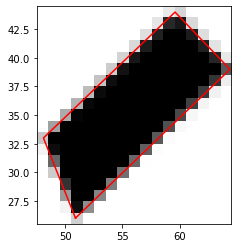

In [8]:
close_shape = np.row_stack((shape,shape[0]))
plt.plot(close_shape[:,0], close_shape[:,1], c='r')

x1, x2 = pixel_offset[1]-0.5, pixel_offset[1]+len(pixels[0])-0.5
y1, y2 = pixel_offset[0]-0.5, pixel_offset[0]+len(pixels)-0.5
plt.imshow(pixels, cmap='binary', origin='lower', vmin=0, vmax=1, extent=(x1, x2, y1, y2))

In [ ]:
(92.7, 66.1) (59.6, 44.0) (56.3, 40.9) (64.4, 39.0)

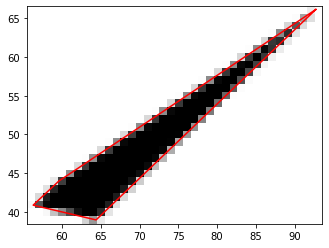

In [10]:
shape = np.array([(92.7, 66.1), (64.4, 39.0), (56.3, 40.9), (59.6, 44.0)])
pixels, pixel_offset = antialiase_shape(shape)
close_shape = np.row_stack((shape,shape[0]))
plt.plot(close_shape[:,0], close_shape[:,1], c='r')

x1, x2 = pixel_offset[1]-0.5, pixel_offset[1]+len(pixels[0])-0.5
y1, y2 = pixel_offset[0]-0.5, pixel_offset[0]+len(pixels)-0.5
plt.imshow(pixels, cmap='binary', origin='lower', vmin=0, vmax=1, extent=(x1, x2, y1, y2))

In [22]:
x = -0.5
np.ceil(x - 0.5), np.ceil(x + 0.5)

(-1.0, 0.0)

In [23]:
quads = [np.array([[0.2,0.3], [1.2,3.2], [5,3.7], [3.2,1]])]
quads.append(np.array([[2,3.6], [1.6,4], [2,4.4], [2.4,4]]))
quads.append(np.array([[2.9,3.3], [1,6.7], [6,5.2], [4.2,3.8]]))
quads.append(np.array([[0.25,0.25], [0.25,2.4], [2.25,2.4], [2.25,0.25]]))
quads.append(np.array([[1,6], [3,9], [7,6], [4,2]]))
quads.append(np.array([[0.6, 4], [1.4,4.1], [3.4,0.4], [2.6,-0.4]]))
quads.append(np.array([[0,-0.4], [0,0.4], [2,0.4], [2,-0.4]]))
quads.append(np.array([[-0.4,-0.4], [-0.4,0.45], [2,0.4], [0.45,-0.3]]))
quads.append(np.array([[0,-0.4], [-0.4,0.45], [2,2], [0.45,-0.3]]))
quads.append(np.array([[31.75, 58.91], [31.29, 59.80],
                       [40.8, 61.99], [40, 61.01]]))

In [24]:
def run():
    for _ in range(1):
        pixels = []
        offsets = []
        for q in quads:
            p, o = antialiase_shape(q)
            pixels.append(p)
            offsets.append(o)
    return pixels, offsets

%time pixels, offsets = run()

Wall time: 9.95 ms


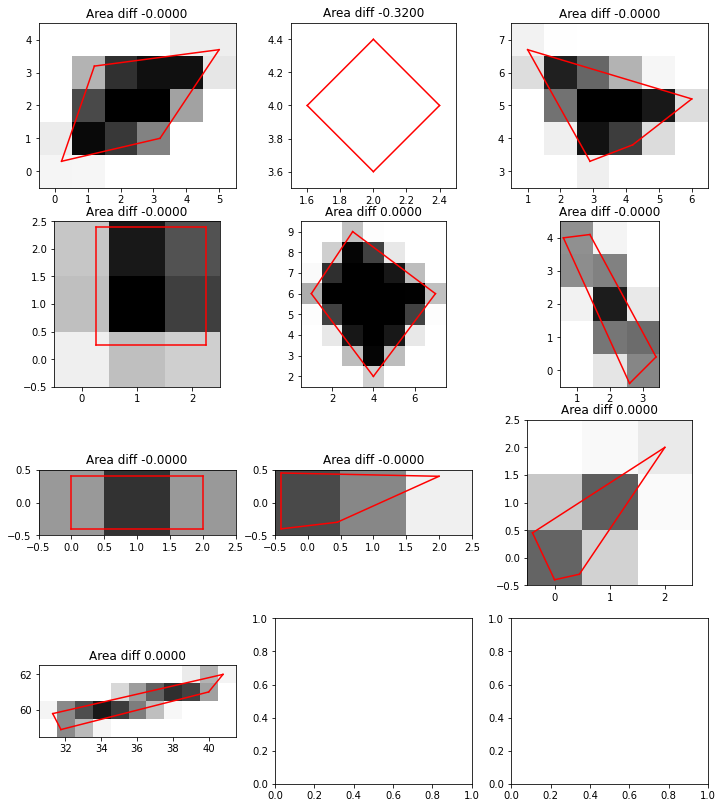

In [25]:
n_rows = int(len(quads)/3)+1
fig, axs = plt.subplots(n_rows, 3, figsize=(12,n_rows*3.5))

count=0
for k in range(len(quads)):
    i,j = k%3, int(k/3)
    d = pixels[k].sum()-area_quadrilateral(quads[k][0],quads[k][1],quads[k][2],quads[k][3])
    axs[j][i].set_title('Area diff %5.4f'%d)
    for l in range(4):
        axs[j][i].plot([quads[k][l,0], quads[k][(l+1)%4,0]], [quads[k][l,1], quads[k][(l+1)%4,1]], c='r')

    axs[j][i].imshow(pixels[k], cmap='binary', origin='lower', vmin=0, vmax=1,
               extent=(offsets[k][1]-0.5, offsets[k][1]+len(pixels[k][0])-0.5, offsets[k][0]-0.5, offsets[k][0]+len(pixels[k])-0.5))

In [19]:
def circle(center, radius, t1=0, t2=2*np.pi, steps=1000):
    thetas = np.linspace(t1, t2, steps+1)[:-1][::-1]
    return (np.array([[np.cos(t), np.sin(t)] for t in thetas])*radius + np.array(center)).T

In [20]:
c = circle([0,0], 2, steps=20).T
p, o = antialiase_shape(c)

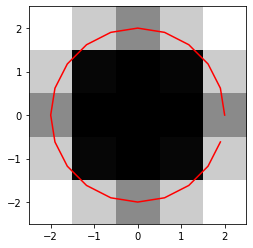

In [21]:
plt.plot(c[:,0],c[:,1], c='r')
plt.imshow(p, cmap='binary', origin='lower', vmin=0, vmax=1, extent=(o[1]-0.5, o[1]+len(p[0])-0.5, o[0]-0.5, o[0]+len(p)-0.5))